$$ R_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k R_{t+k+1} $$

$$ L = \left( R_t + \gamma^n \max_{a'} Q(S_{t+n}, a') - Q(S_t, A_t) \right)^2 $$


Episode 0: 12.0
Episode 1: 12.0
Episode 2: 19.0
Episode 3: 14.0
Episode 4: 14.0
Episode 5: 11.0
Episode 6: 13.0
Episode 7: 13.0
Episode 8: 17.0
Episode 9: 13.0
Episode 10: 11.0
Episode 11: 14.0
Episode 12: 10.0
Episode 13: 11.0
Episode 14: 10.0
Episode 15: 9.0
Episode 16: 12.0
Episode 17: 11.0
Episode 18: 12.0
Episode 19: 11.0
Episode 20: 24.0
Episode 21: 8.0
Episode 22: 12.0
Episode 23: 8.0
Episode 24: 10.0
Episode 25: 36.0
Episode 26: 13.0
Episode 27: 59.0
Episode 28: 24.0
Episode 29: 18.0
Episode 30: 40.0
Episode 31: 16.0
Episode 32: 38.0
Episode 33: 16.0
Episode 34: 39.0
Episode 35: 38.0
Episode 36: 24.0
Episode 37: 52.0
Episode 38: 42.0
Episode 39: 16.0
Episode 40: 39.0
Episode 41: 57.0
Episode 42: 69.0
Episode 43: 46.0
Episode 44: 86.0
Episode 45: 69.0
Episode 46: 83.0
Episode 47: 151.0
Episode 48: 118.0
Episode 49: 305.0
Episode 50: 136.0
Episode 51: 231.0
Episode 52: 212.0
Episode 53: 195.0
Episode 54: 197.0
Episode 55: 182.0
Episode 56: 341.0
Episode 57: 204.0
Episode 58: 321.

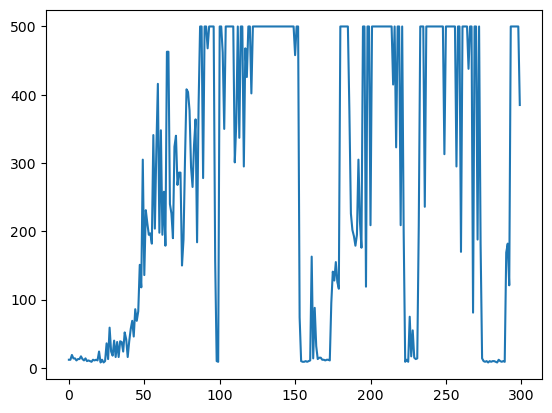

In [9]:
import gymnasium as gym
import torch as th
from Algorithms.Agents.BaseAgent import BaseAgent
import matplotlib.pyplot as plt 


class NstepAgent(BaseAgent):
    def __init__(self, _env: gym.envs, use_conv=True, _lr=3e-4, _gamma=0.99, _buffer_size=10000, _nsteps=3):
        super().__init__(_env, use_conv, _lr, _gamma, _buffer_size)
        self.nsteps, self.nstep_buffer = _nsteps, []
        self.learn_start = 100 # todo maybe make them attrs of the BaseAgent
        self.update_freq = 1
        
    def append_to_replay(self, s, a, r, s_, te, tr):
        self.nstep_buffer.append((s,a,r,s_))
        if len(self.nstep_buffer) < self.nsteps:
            return # todo why return and not break or pass ? do we need to return something ?
        
        R = sum([self.nstep_buffer[i][2] * (self.gamma ** i) for i in range(self.nsteps)])
        _state, _action, _, _ = self.nstep_buffer.pop(0)
        
        self.replay_buffer.push(_state, _action, R, s_, te, tr)
        
    def update(self, s ,a , r, s_, te, tr):
        self.frame += 1
        self.append_to_replay( s ,a , r, s_, te, tr)
        # todo add clip -1, 1, add learn_start frame
        
        if self.frame < self.learn_start or self.frame % self.update_freq != 0:
            return None
        
        _batch = self.replay_buffer.sample(self.batch_size)
        loss = self.compute_loss(_batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def finish_nstep(self):
        while len(self.nstep_buffer) > 0:
            R = sum([self.nstep_buffer[i][2]*(self.gamma**i) for i in range(len(self.nstep_buffer))])
            _state, _action, _, _ = self.nstep_buffer.pop(0)

            self.replay_buffer.push((_state, _action, R, None))

env = gym.make('CartPole-v1')

episode_reward = 0
batch_size = 32
max_episodes = 300
max_steps = 1000

# Initialize your DQN model
agent = NstepAgent(env, use_conv=False)

episode_rewards = []

for episode in range(max_episodes):
    episode_reward = 0
    state = env.reset()[0]
    state = th.tensor(state, dtype=th.float32).to(agent.device)

    for step in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        next_state = th.tensor(next_state, dtype=th.float32).to(agent.device)
        agent.replay_buffer.push(state, action, reward, next_state, term, trunc)

        episode_reward += reward

        agent.update(state, action, reward, next_state, term, trunc)

        if term or trunc:
            episode_rewards.append(episode_reward)
            print(f"Episode {episode}: {episode_reward}")
            break

        state = next_state

plt.plot(episode_rewards)

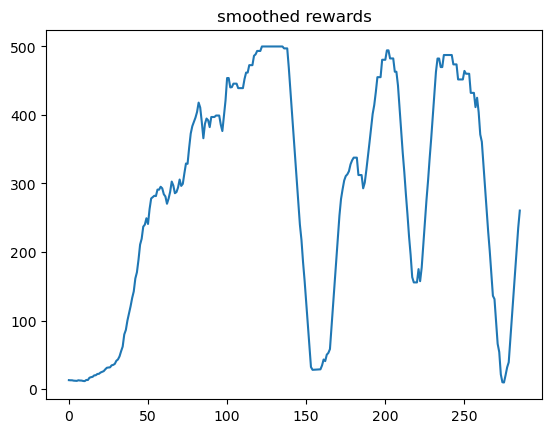

In [10]:
import numpy as np


# Smoothed: 
def moving_average(data, _window_size):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    return (cumsum_vec[_window_size:] - cumsum_vec[:-_window_size]) / _window_size


window_size = 15
smoothed_rew = moving_average(episode_rewards, window_size)
plt.plot(smoothed_rew)
plt.title('smoothed rewards')
plt.show()
